# Imports

In [1]:
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
from datetime import datetime
import numpy as np
import random
import seaborn as sns
from typing import Optional, Tuple, Union
import matplotlib.pyplot as plt
from syntheval import SynthEval
from tqdm.notebook import tqdm  # für Jupyter kompatibel

# User Settings

In [2]:
@dataclass
class Config:
    data_dir: Path = Path("../../data")
    figures_dir: Path = Path("figures")
    results_dir: Path = Path("results")

    real_file: str = "20250301_data_20250510_122405_final_100_train.csv"
    synth_file: str = "20250301_data_20250510_122405_final_100_synth.csv"
    holdout_file: str = "20250301_data_20250510_122405_final_100_holdout.csv"

    random_seed: int = 42
    bootstrap_size = 5000
    n_bootstrap = 30
    replace = True
    thres = 0.05

    save_data: bool = True

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)


# Utility Functions

In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        # df[col] = df[col].astype('category')
        df[col] = df[col].astype('object') # 'category' führt zu Problemen mit dem OneHotEncoder

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')
        # df[col] = df[col].astype('int32')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = None,
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

# Main Routine
## Data Import

In [4]:
cfg = Config()
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df_train, df_synth, df_holdout = load_data(
    cfg.real_file,
    cfg.synth_file,
    cfg.holdout_file,
    data_dir=cfg.data_dir
)

df_holdout = df_holdout.dropna().reset_index(drop=True)

In [5]:
target_col = 'icu_admission_24h'
num_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block', 'night_arrival', 'weekend_arrival']
ord_cols = ['consciousness_level','news_score']
bool_cols = ['night_arrival', 'weekend_arrival']

cat_ord_cols = cat_cols + ord_cols
cat_ord_cols.append(target_col)
print(cat_ord_cols)

['gender', 'ethnicity', 'chief_complaint', 'icd_block', 'night_arrival', 'weekend_arrival', 'consciousness_level', 'news_score', 'icu_admission_24h']


## Train -> Synth

In [6]:
results_train_synth = []

for boot in tqdm(range(cfg.n_bootstrap), desc="Bootstrap"):
    # Ziehe 5.000 zufällige Zeilen aus Train und Synth
    tr_sample = df_train.sample(cfg.bootstrap_size, replace=cfg.replace, random_state=cfg.random_seed + boot)
    sy_sample = df_synth.sample(cfg.bootstrap_size, replace=cfg.replace, random_state=cfg.random_seed + boot)

    # Hitting-Rate berechnen
    Train_vs_Synth = SynthEval(real_dataframe=tr_sample, cat_cols=cat_ord_cols, verbose=False)
    res = Train_vs_Synth.evaluate(sy_sample, hit_rate={'thres_percent': cfg.thres})
    val = res.loc[res['metric']=='hit_rate', 'val'].iloc[0]

    results_train_synth.append({'bootstrap': boot, 'val': val})

Bootstrap:   0%|          | 0/30 [00:00<?, ?it/s]

## Holdout -> Synth

In [7]:
results_holdout_synth = []

for boot in tqdm(range(cfg.n_bootstrap), desc="Bootstrap"):
    # Ziehe 5.000 zufällige Zeilen aus Train und Synth
    ho_sample = df_holdout.sample(cfg.bootstrap_size, replace=cfg.replace, random_state=cfg.random_seed + boot)
    sy_sample = df_synth.sample(cfg.bootstrap_size, replace=cfg.replace, random_state=cfg.random_seed + boot)

    # Hitting-Rate berechnen
    Holdout_vs_Synth = SynthEval(real_dataframe=ho_sample, cat_cols=cat_ord_cols, verbose=False)
    res = Holdout_vs_Synth.evaluate(sy_sample, hit_rate={'thres_percent': cfg.thres})
    val = res.loc[res['metric']=='hit_rate', 'val'].iloc[0]

    results_holdout_synth.append({'bootstrap': boot, 'val': val})

Bootstrap:   0%|          | 0/30 [00:00<?, ?it/s]

## Aggregation

In [ ]:
# In DataFrames umwandeln
df_train_synth = pd.DataFrame(results_train_synth)
df_train_synth['comparison'] = 'Train vs. Synth'

df_holdout_synth = pd.DataFrame(results_holdout_synth)
df_holdout_synth['comparison'] = 'Holdout vs. Synth'

# Zusammenführen
df_results = pd.concat([df_train_synth, df_holdout_synth], ignore_index=True)

if cfg.save_data:
    # Speichern der Ergebnisse
    df_results.to_csv(cfg.results_dir / f"hitting-rate_results_{current_timestamp}.csv", index=False, header=True, decimal=',', sep=';', encoding='utf-8')

          comparison      mean       sem
0  Holdout vs. Synth  0.000087  0.000025
1    Train vs. Synth  0.000053  0.000019


In [6]:
df_results = pd.read_csv(cfg.results_dir / f"hitting-rate_results_20250516_064959.csv", sep=';', decimal=',', encoding='utf-8')

In [8]:
# Aggregation: Mittelwert und Standardfehler je Vergleich
summary = df_results.groupby('comparison')['val'].agg(['mean', 'sem']).reset_index()
print(summary)

          comparison      mean       sem
0  Holdout vs. Synth  0.000087  0.000025
1    Train vs. Synth  0.000053  0.000019


## Visualisierung

Abbildung gespeichert unter: figures\hitting-rate_s-5000_n-30_tresh-0.05_20250601_155621.tiff


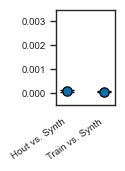

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(1.2, 1.725))

# 1) Draw the point‐plot (no built‐in errorbars)
sns.pointplot(
    ax=ax,
    data=summary,
    x="comparison",
    y="mean",
    errorbar=None,      # turn off Seaborn's CI bars
    linestyle="none",
    markersize=6,
    color="black",
)

# 2) Grab the x‐positions that pointplot actually placed the points at:
x_positions = ax.get_xticks()

# 3) Add your own error bars at exactly those x‐positions:
ax.errorbar(
    x=x_positions,
    y=summary["mean"],
    yerr=summary["sem"],
    fmt="o",
    ecolor="black",
    capsize=5,
)

# --- axis labels / title / limits ---
ax.set_ylabel("")       # no y‐label text
ax.set_xlabel("")       # no x‐label text
# ax.set_title("Hitting Rate")
ax.set_xmargin(0.3)
ax.set_ylim(-0.0005, 0.0035)

# --- force y‐axis ticks on the left (and make them visible) ---
ax.yaxis.set_ticks_position("left")
ax.tick_params(
    axis="y",
    which="both",
    left=True,
    right=False,
    labelleft=True,
    length=4,
    width=1,
    direction="out",
)

# --- set custom x‐tick labels at those same positions ---
ax.set_xticks(x_positions)
ax.set_xticklabels(
    ["Hout vs. Synth", "Train vs. Synth"],
    rotation=35,
    ha="right",
)

plt.tight_layout()
if cfg.save_data:
    fname = f'hitting-rate_s-{cfg.bootstrap_size}_n-{cfg.n_bootstrap}_tresh-{cfg.thres}_{current_timestamp}.tiff'
    fullpath = cfg.figures_dir / f'{fname}'
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.show()
